## Import Library

In [9]:
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend" #for Mac
#os.environ["CUDA_VISIBLE_DEVICES"]='0'
#os.environ["CUDA_VISIBLE_DEVICES"]='1'
import keras
#import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Load Data and Preprocessing

In [5]:
data = pd.read_csv("./Processed_data_final_ver2.csv")
X_data = data.drop(["label","label2"],axis=1)
y_data = data["label2"]

import imblearn
X_data, y_data = imblearn.under_sampling.RandomUnderSampler(sampling_strategy='majority', random_state=1004)\
    .fit_resample(X_data, y_data)

y_data[y_data == "four"] = 1
y_data[y_data == "good"] = 2
y_data[y_data == "gun"] = 3
y_data[y_data == "okay"] = 4
y_data[y_data == "one"] = 5
y_data[y_data == "paper"] = 6
y_data[y_data == "rock"] = 7
y_data[y_data == "rest"] = 0
y_data[y_data == "scissor"] = 8
y_data[y_data == "three"] = 9

#%% Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.1, stratify=y_data, random_state=1004)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train))
X_test_scaled = pd.DataFrame(scaler.transform(X_test))

## Model

In [6]:
def my_model(hidden_layer_num, node_size, batch_normalization, drop_out, drop_out_rate, learning_rate):
    model = keras.Sequential()
    
    ### Input Layer
    model.add(keras.layers.InputLayer(input_shape=(18,)))
    
    ### Hidden Layer
    for i in range(hidden_layer_num):
        model.add(keras.layers.Dense(node_size))
        if batch_normalization: model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.ReLU())
        if drop_out: model.add(keras.layers.Dropout(drop_out_rate))    
    
    ### Output Layer
    model.add(keras.layers.Dense(10))
    model.add(keras.layers.Softmax())
    
    ### Compile
    model.compile(optimizer= keras.optimizers.Adam(learning_rate), 
                  loss='sparse_categorical_crossentropy', 
                  metrics=["accuracy"])
    
    return model

## Generate Keras Classifier and Grid_Search CV

ANN Test Score hidden_layer_2 : 0.5032663259973478


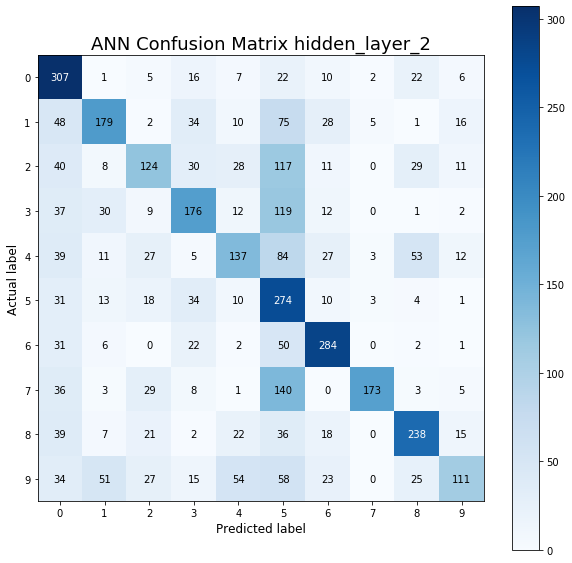

ANN Test Score hidden_layer_3 : 0.4701004971810921


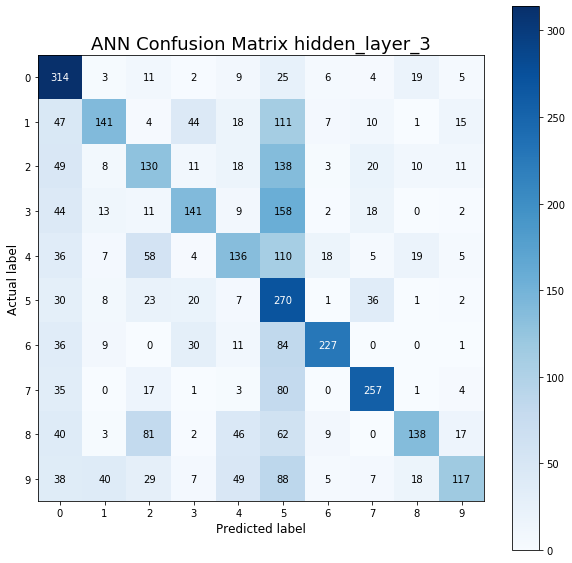

ANN Test Score hidden_layer_4 : 0.48040200552748674


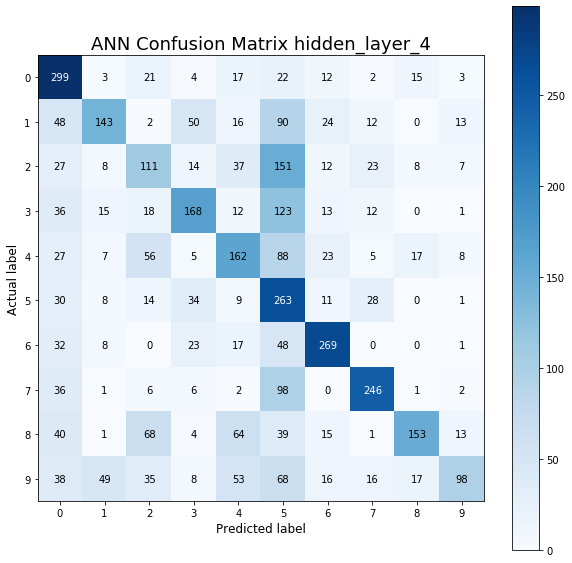

In [10]:
#%% Generate Keras Classifier
from tqdm.notebook import tqdm 
#from tqdm import tqdm
from keras.wrappers.scikit_learn import KerasClassifier
import mglearn
from matplotlib.pyplot import savefig

model = KerasClassifier(build_fn=my_model, verbose=0)

from sklearn.model_selection import GridSearchCV
#from keras_tqdm import TQDMNotebookCallback


df_result = pd.DataFrame()

hidden_layer_num = [2, 3, 4]


for i in tqdm(hidden_layer_num):
      
    parameter = {'hidden_layer_num' : [i], 
                 "node_size": [300, 600, 1000], 
                 'drop_out': [True], 
                 'batch_normalization' : [True], 
                 'drop_out_rate': [0.2, 0.3, 0.4], 
                 'learning_rate': [0.001], 
                 'epochs':[1], 
                 'batch_size':[2**10], 
                 #'callbacks':[TQDMNotebookCallback()]
                }
    
    grid_search = GridSearchCV(estimator= model, param_grid=parameter, n_jobs=1, cv=2)

    # Grid Search 
    grid_search.fit(X_train_scaled, y_train)

    # Test Score
    ann_test_score = grid_search.score(X_test_scaled, y_test)
    print("ANN Test Score hidden_layer_" + str(i) + " : {0}".format(ann_test_score))

    # Confusion Matrix
    plt.rcParams['figure.figsize'] = (10, 10) #figure size
    plt.rcParams.update({'axes.labelsize': 'large'}) #axes label size
    
    scores_image = mglearn.tools.heatmap(
        confusion_matrix(np.array(y_test).astype('int'), grid_search.predict(X_test_scaled).astype('int')), 
        xlabel='Predicted label', 
        ylabel='Actual label', xticklabels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], yticklabels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], cmap='Blues', fmt="%d")
    
    plt.title("ANN Confusion Matrix " + "hidden_layer_" + str(i), fontsize=18)
    plt.gca().invert_yaxis()
    plt.colorbar(scores_image)
    savefig(fname="ANN_Confusion_Matrix " +  "hidden_layer_" + str(i) + ".png")
    plt.show()
    
    result = grid_search.cv_results_

    df_result = df_result.append(pd.DataFrame(result), ignore_index=True)

## Save Results

In [11]:
#%% Save Results
    
df_result.to_csv("./Result/ann_grid_result.csv", encoding="CP949", index=False)